# 1. Business Understanding
**Objective:** Develop a robust machine learning model that can accurately classify handwritten digits (0-9), despite variations in handwriting styles.

**Challenges:** High intra-class variance due to different writing styles, potential noise in images, and class imbalance.

**Success Criteria:** Model performance will be evaluated based on accuracy, precision, recall, and robustness to difficult cases.

# 2. Data Understanding
**Dataset:** The MNIST dataset, containing 70,000 gray scale images (60,000 for training, 10,000 for testing), each sized 28x28 pixels.
## Feature Considerations:
- Presence of closed loops (e.g., 0, 6, 8)
- Stroke thickness variation
- Aspect ratios and curvatures (e.g., distinguishing 1 from 7)
- Edge detection and texture information

# 3. Data Preparation


### Preprocessing Steps:

#### Cleaning the Images
- Normalize pixel values (0-255 → 0-1)
- Apply data augmentation (rotation, shifting, noise addition) to improve generalization


##### Explanation
Each pixel in the image is not in a binary state, they are on a gray scale which value can range from 0 to 255. So we first normalize every pixel to be a value of 0 or 1, which helps clean up the images a little.

The result of this can cause the image is not most likely very noisy. So a GaussianBlur is applied to "smooths" out the image high frequency components and acts as a low-pass filter, with the goal of preserving the edges and boundaries of the number inside the image [1]. Or to but it another way: After we have applied the GaussianBlur, the hope is that there is only one connected set of pixels that make up the number inside the image, an there should be no orphans or single islands else where.

Finally, we can use Binarization [2] to simplify features extraction later by highlighting digit strokes clearly. 

loaded dataset from file. Shape of Images data set: (70000, 784)


100%|██████████| 70000/70000 [00:01<00:00, 40576.95it/s]

data pre processing compete!
Random sample image comparison:


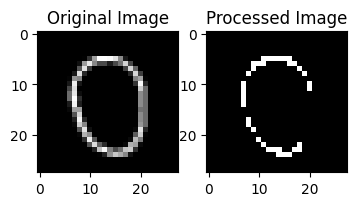

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from Scripts.image_data_container import ImageData

dataArrays = np.load("Imports/mnist_combined.npz")
imageDataObject = ImageData(dataArrays)

# select ransom image to sample and make sure everything is working.
imageSampleIndex = np.random.randint(0,len(imageDataObject.dataImages))
sampleImage = (imageDataObject.dataImages[imageSampleIndex].reshape(28,28)).copy()

for i in tqdm(range(0,len(imageDataObject.dataImages))):
    # this is taking the i entry from the data images and pre processing it.
    # the thing to keep in mind is that this will go from an array that looks like
    # this: (70000,784) to an array that looks like this (1,784), rule is to always append 
    # a 1 to the beginning. 
    image_original = imageDataObject.dataImages[i]
    testImage = image_original
    # reshape the return since it expects (1,784) 
    imageDataObject.dataImages[i] = imageDataObject.PreProcessImage(testImage).reshape(1,784)

print ("data pre processing compete!")
print ("Random sample image comparison:")
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.imshow(sampleImage, cmap='gray')
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(imageDataObject.dataImages[imageSampleIndex].reshape(28,28), cmap='gray')
plt.title("Processed Image")
plt.show()


Above is the result of the preprocessing steps that have been taken. all pixels have been normalized to be value of ether 0 or 1 instead of a random between 0 and 255. Doing so helps to reduce the amount of information that the models will have take into account. This reduction in complexity also helps with feature classification and identification sept that will be taken next.

#### Extraction Steps
- Edge direction for stroke shape vector creation (Histogram of Oriented Gradients [4] [5] [6]).
- Edge filtering using Sobel filter. [7]
- Image Zoning for pixel shape similarity identification comparison.
- Complexity reduction (dimensionality) using projection features. [8]

##### Explanation
**Histogram of Oriented Gradients (HOG):** builds a representation of the objects shape by recording the direction of each edge in a collection of cells, each cell being a small part of the overall image, forming a number of histograms that can be combined to represent the objects shape. for example; how do we know that the image is a square box? We take our input image and split it into a 2 by 2 grid of cells, consisting of 1 by 1 pixels each, and sum up all the cells histograms to the following: [2,2,2,2] it is possible to determine that the "shape" of the object in the image makes a closed box.

**Sobel filtering:** compares the change in brightness of each pixel in the image, for both the horizontal direction and vertical direction. By marking a areas where there is a considerable change in this brightness as an edge, we can remove a large amount of unnecessary information from the image (noise reduction). By combining both horizontal and vertical directions, we can build an outline of the objects in the image.

**Image zoning:** is the process of breaking the image down into smaller "chunks" to help identify a larger number of patterns rather than one singular patter if we just focused on the image as a whole. This is also helpful when parts of the image is distorted or "smudged" in some way, for example if someone writes a 9 more like a y (not closing the top loop) if the whole number of looked at it could be miss classified more easily. But if you look at multiple parts of the image there is still a 90% similarity, and we could more confidently classify the shape as a 9.

**Hu moments:** Although I do not believe that this is needed since the data set should already have been cleaned of this, based on my understanding of it. We also have to take into consideration that a Hu moment on their own can and will struggle to distinguish between numbers that are mirrored, eg. 6 and 9 will look the same if we only take the Hu moment of the image. But it does come in handy if someone has written an 8 on its side by or not drawn a perfectly vertical 1 or 7.

**Projection Features:** By taking the image and "squashing" it along the horizontal or vertical plane, we can quickly determine the concentration of key areas of the number. For example if we take a number 7 and project it along the horizontal plane, we should expect a large concentration of pixels around the top half of the projection. where as the vertical projection should be roughly equal. Horizontal: [0,4,1,1,1,1,1,1] and Vertical: [0,1,1,1,1,1,1,1]. 

### Running the code
bellow is an example of the extract features code runs. Most of the code has been moved into the ImageData object to reduce the length of this document, comments have been placed onto the code to explain steps.

In [11]:
from Scripts.image_data_container import ImageData
# Extract features, pass in the "Cleaned" processed image.
features = imageDataObject.Extract_features(imageDataObject.dataImages[4].reshape(28,28))

#Look into if the features.shape is just the size of data extracted?? I am still unsure as to what this exactly means.
## ANSWER:: the extracted features are always a fixed size because the input image is a fixed size, and we are not changing the umber of
##          features being extracted. So think of the value returned by the shape being the size of data being extracted from each image.

print("Extracted feature vectors for testing shape:", features.shape)


Extracted feature vectors for testing shape: (2159,)


Multiple features have been extracted from sample image. These features are used later when running the models instead of the images themselves. Doing so allows us to have better control over what each model is looking for during training and testing.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

print("Extracting features from all images in the data set.")
# Process and extract features for the first 10,000 samples (balances performance vs. accuracy) [2]
samples = 10000
featureArray = np.array([imageDataObject.Extract_features(img.copy().reshape(28,28)) 
                         for img in tqdm(imageDataObject.dataImages[:samples])])

# write features to file so we dont have to run this all the time.
# since the features wont change that often.
print("Writing extracted features to csv file....")
rawFeaturesDataFrame = pd.DataFrame(featureArray)
rawFeaturesDataFrame.insert(0, "labels", imageDataObject.dataLabels[:samples])
rawFeaturesDataFrame.to_csv("Exports/processedFeatures.csv", index=False)
print("Add features written to csv file and exported to Exports folder.")


print("Reducing and standardizing extracted features...")
# Standardization: Ensures all features have the same scale before PCA
scaler = StandardScaler()
featuresScaled = scaler.fit_transform(featureArray)
# we still want to save all the features later for training.
# Principal Component Analysis (PCA) helps reduce dimensionality
# while trying to preserve as much variance as possible.
reduction = 100
pca = PCA(n_components=reduction)
featuresPCA = pca.fit_transform(featuresScaled)
# saved reduced feature sets to csv
pacFeaturesDataFrame = pd.DataFrame(featuresPCA)
pacFeaturesDataFrame.insert(0,"labels", imageDataObject.dataLabels[:samples])
pacFeaturesDataFrame.to_csv("Exports/pacFeatures.csv", index = False)
print("Finished reducing and standardizing extracted features, and save to csv files inside Exports folder.")



Extracting features from all images in the data set.


100%|██████████| 10000/10000 [00:08<00:00, 1212.80it/s]


Writing extracted features to csv file....
Add features written to csv file and exported to Exports folder.
Reducing and standardizing extracted features...
Finished reducing and standardizing extracted features, and save to csv files inside Exports folder.


Save the extracted features to a csv file for later used. saves on storing over a GB in memory.

# 4. Modeling & Evaluation
**Baseline Model:** K-NN for quick benchmarking.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
features_train, features_test, labels_train, labels_test =  train_test_split(featuresScaled, imageDataObject.dataLabels[:samples], test_size=0.2, random_state=42)

# Initialize and train K-NN classifier
knn = KNeighborsClassifier(n_neighbors=5) # using k=5
knn.fit(features_train, labels_train)

# Make predictions
labelPrediction = knn.predict(features_test)

# Evaluate the model
accuracy = accuracy_score(labels_test, labelPrediction)
print("K-NN Accuracy: ", accuracy)
print("Classification Report: \n", classification_report(labels_test, labelPrediction))

print("Features extraction and basic benchmarking completed! Shape of feature set: ", featuresScaled.shape)

K-NN Accuracy:  0.9235
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       207
           1       0.94      0.99      0.97       216
           2       0.94      0.92      0.93       204
           3       0.88      0.87      0.87       192
           4       0.97      0.88      0.92       211
           5       0.90      0.87      0.88       176
           6       0.97      0.96      0.97       220
           7       0.94      0.89      0.91       216
           8       0.93      0.90      0.91       166
           9       0.83      0.93      0.88       192

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

Features extraction and basic benchmarking completed! Shape of feature set:  (10000, 2159)


## Overview
K-Nearest Neighbors (K-NN) is a simple and effective classifier that provides a initial performance benchmark before implementing more complex models. K-NN also is useful for the hand written numbers data sets, as it does not make assumptions about data distribution since there can be a wide range of extracted features coming from the hand written numbers. 

## Conclusions
Hopefully an accuracy of over 90% should indicate that the ime pre-processing steps taken have been effective. Meaning we should be safe to move forward to more complicated LM Model.

## Moving Forward
I am planning on testing the implementation of a Support Vector Machine first, and then moving onto possibly Random Forest. Then performing a comparison between the two to see which one can predict the correct numbers with a higher accuracy.

# ML Approaches:
SVM offers very high accuracy compared to other classifiers such as logistic regression, and decision trees. It is known for its kernel trick to handle nonlinear input spaces. It is used in a variety of applications such as face detection, intrusion detection, classification of emails, news articles and web pages, classification of genes, and handwriting recognition. [9]

SVM Accuracy: 0.9485


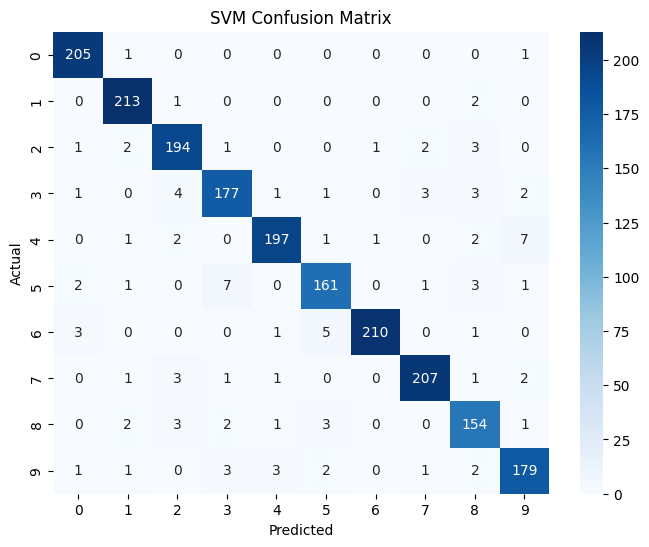

SVM model training and evaluation completed!


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from skimage.feature import hog
from skimage.filters import sobel
from skimage.morphology import dilation, erosion, disk
from skimage.measure import moments_hu
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import cv2

# Step 1: Load processed feature data from CSV
pca_features_df = pd.read_csv("Exports/pacFeatures.csv")
X = pca_features_df.drop(columns=["labels"]).values
y = pca_features_df["labels"].values

# Step 2: Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train SVM Classifier
svm = SVC(kernel='linear')  # Using a linear kernel for baseline performance
svm.fit(X_train, y_train)

# Step 4: Make predictions
y_pred = svm.predict(X_test)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("SVM Accuracy:", accuracy)

# Step 6: Visualize results
# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()

print("SVM model training and evaluation completed!")

### Data Loading and Preparation
The PCA-transformed features are loaded from pca_features.csv.
The dataset is split into training (80%) and testing (20%) sets using train_test_split().
### Training the SVM Model
An SVM (Support Vector Machine) classifier is initialized with a linear kernel (SVC(kernel='linear')).
The model is trained on the training set (X_train, y_train) using svm.fit().
The SVM finds the optimal hyperplane that separates different digit classes in the feature space.
### Prediction and Evaluation
The trained SVM model predicts digit labels for the test set (X_test).
Accuracy is calculated to measure overall correctness.
### Visualization of Results
Confusion Matrix Heatmap:
Displays where the model misclassified digits.
A perfect model would have values only on the diagonal (true positive matches).
Accuracy Bar Chart:
Shows the overall accuracy of the SVM model in a simple, visual format.

# 5. Evaluation (ToDO)
**Metrics:**
- Accuracy (primary metric)
- Confusion Matrix to analyze misclassifications
- Precision, Recall, F1-score for class-specific performance
- Robustness Testing:
- Evaluate on distorted and rotated images
- Assess performance on ambiguous samples

# 6. References
## Image pre-processing
[1]“Gaussian Blur - an overview | ScienceDirect Topics,” www.sciencedirect.com. https://www.sciencedirect.com/topics/engineering/gaussian-blur

[2]“Python | Thresholding techniques using OpenCV | Set-1 (Simple Thresholding) - GeeksforGeeks,” GeeksforGeeks, May 06, 2019. https://www.geeksforgeeks.org/python-thresholding-techniques-using-opencv-set-1-simple-thresholding/
‌

[3]F. Daghero, D. J. Pagliari, and M. Poncino, “Energy-efficient deep learning inference on edge devices,” Advances in Computers, pp. 247–301, 2021, doi: https://doi.org/10.1016/bs.adcom.2020.07.002.

## Histogram of Gradients
[4]UCF CRCV, “Lecture 9.3: Features [Histogram of Gradients] [HOG],” YouTube, Jul. 26, 2023. https://www.youtube.com/watch?v=92-NaIdIrEs (accessed Mar. 15, 2025).
‌‌

[5]R. Manavalan, “Automatic identification of diseases in grains crops through computational approaches: A review,” Computers and Electronics in Agriculture, vol. 178, p. 105802, Nov. 2020, doi: https://doi.org/10.1016/j.compag.2020.105802.


[6]Skillcate AI, “HOG Intuition | Simple Explanation | Feature Descriptor & Engineering,” YouTube, Jun. 13, 2021. https://www.youtube.com/watch?v=5nZGnYPyKLU (accessed Mar. 15, 2025).

## Sobel Filter
[7]“Sobel Filter - an overview | ScienceDirect Topics,” www.sciencedirect.com. https://www.sciencedirect.com/topics/computer-science/sobel-filter

## Dimensionality reduction
[8]C. Angermann and M. Haltmeier, “Deep structure learning using feature extraction in trained projection space,” Computers & Electrical Engineering, vol. 92, p. 107097, Jun. 2021, doi: https://doi.org/10.1016/j.compeleceng.2021.107097.
‌
##  SVM
[9]A. Navlani, “Scikit-learn SVM Tutorial with Python (Support Vector Machines),” www.datacamp.com, Dec. 2019. https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python


[10]V. N. Vapnik, “An overview of statistical learning theory,” IEEE Transactions on Neural Networks, vol. 10, no. 5, pp. 988–999, 1999, doi: https://doi.org/10.1109/72.788640.
‌
‌

‌
‌